In [1]:
from collections import defaultdict
import pickle
from dataclasses import dataclass
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from rmgpy.data.kinetics import KineticsDatabase
from rmgpy.kinetics import (Arrhenius, ArrheniusBM, ArrheniusEP, Chebyshev,
                            KineticsData, Lindemann, MultiArrhenius,
                            MultiPDepArrhenius, PDepArrhenius,
                            StickingCoefficient, StickingCoefficientBEP,
                            SurfaceArrhenius, SurfaceArrheniusBEP, ThirdBody,
                            Troe)
from rmgpy.kinetics.model import KineticsModel
from rmgpy.reaction import Reaction

@dataclass
class Reaction:
    family_name: str
    depo_label: str
    indepo_index: int
    reaction: Reaction
    kinetics_property: KineticsModel
    rank: int

In [2]:
%matplotlib inline

# Load from kinetic database

In [3]:
print("loading rmg kinetic database ....")
kdb = KineticsDatabase()
kdb.load_libraries("/rmg/RMG-database/input/kinetics/libraries")
print("done")

loading rmg kinetic database ....


done


# Data exploration

In [4]:
library_reaction_list = []
for library_name in tqdm(kdb.libraries, desc="library"):

    lib = kdb.libraries[library_name]
    for reaction_index in lib.entries:
        rxn = lib.entries[reaction_index]
        reaction = Reaction(
            family_name=library_name,
            depo_label=None,
            indepo_index=rxn.index,
            reaction=rxn.item,
            kinetics_property=rxn.data,
            rank=rxn.rank
        )
        library_reaction_list.append(reaction)

with open("library_reactions.pickle", 'wb') as f:
    pickle.dump(library_reaction_list, f)
print(len(library_reaction_list), " reactions collected")

library:   0%|          | 0/174 [00:00<?, ?it/s]

33010  reactions collected


# Reaction to Input and Output

In [5]:
def input2reaction_smiles(sample: Reaction):
    reaction_smiles = ""
    
    smiles = []
    for sp in sample.reaction.reactants:
        smiles.append(
            sp.smiles
        )
        
    reaction_smiles += ".".join(smiles)
    
    reaction_smiles += ">>"
    
    smiles = []
    for sp in sample.reaction.products:
        smiles.append(
            sp.smiles
    )
    
    reaction_smiles += ".".join(smiles)
    return reaction_smiles


In [6]:
def input2reaction_label(sample: Reaction):
    return sample.reaction.to_labeled_str()

# RMG-Library for conditional OOD

In [51]:
T_smiles_key_dict = defaultdict(list)
T_reaction_list = []

TP_smiles_key_dict = defaultdict(list)
TP_reaction_list = []

for sample in library_reaction_list:
    k = sample.kinetics_property
    smiles = input2reaction_smiles(sample)

    if k.is_pressure_dependent():
        TP_smiles_key_dict[smiles].append(sample)
        TP_reaction_list.append(sample)
    else:
        T_smiles_key_dict[smiles].append(sample)
        T_reaction_list.append(sample)

### Redundancy check

In [52]:
T_reaction_list_reduced = []
for smiles in T_smiles_key_dict:
    redundancy_counts = len(T_smiles_key_dict[smiles])
    if redundancy_counts == 1:
        T_reaction_list_reduced.extend(T_smiles_key_dict[smiles])

In [53]:
TP_reaction_list_reduced = []
for smiles in TP_smiles_key_dict:
    redundancy_counts = len(TP_smiles_key_dict[smiles])
    if redundancy_counts == 1:
        TP_reaction_list_reduced.extend(TP_smiles_key_dict[smiles])

In [54]:
print("Total number of reaction kinetics records: ",
      len(library_reaction_list))

print("---"*10, "temperature dependence", "---"*10)
      
print("Total number of temperature dependent reaction kinetics records: ",
      len(T_reaction_list))      
print("Total number of unique reaction smiles: ",
      len(T_smiles_key_dict))
print("Total number of reaction smiles with only one occurance: ",
      len(T_reaction_list_reduced))

print("---"*10, "temperature and pressure dependence", "---"*10)

print("Total number of temperature and pressure dependent reaction kinetics records: ",
      len(TP_reaction_list))
print("Total number of unique reaction smiles: ",
      len(TP_smiles_key_dict))
print("Total number of reaction smiles with only one occurance: ",
      len(TP_reaction_list_reduced))

Total number of reaction kinetics records:  33010
------------------------------ temperature dependence ------------------------------
Total number of temperature dependent reaction kinetics records:  29539
Total number of unique reaction smiles:  11793
Total number of reaction smiles with only one occurance:  6446
------------------------------ temperature and pressure dependence ------------------------------
Total number of temperature and pressure dependent reaction kinetics records:  3471
Total number of unique reaction smiles:  1451
Total number of reaction smiles with only one occurance:  861


## Temperature dependence

### Redundancy reduced

In [55]:
intervals = []
for sample in T_reaction_list_reduced:
    k = sample.kinetics_property
    if k.is_pressure_dependent():
        continue

    if k.Tmin is not None:
        intervals.append((k.Tmin.value_si, k.Tmax.value_si))

print(len(intervals))

280


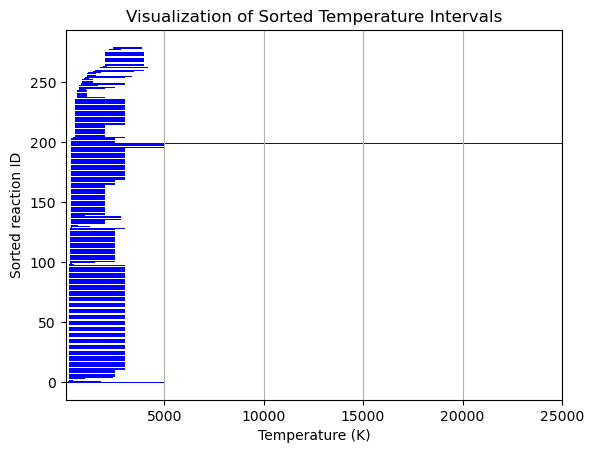

In [56]:
# Sort intervals based on the left limit
sorted_intervals = sorted(intervals, key=lambda x: x[1])
sorted_intervals = sorted(sorted_intervals, key=lambda x: x[0])

# Extract left and right limits from sorted intervals
left_limits, right_limits = zip(*sorted_intervals)

global_t_min = min(left_limits)
global_t_max = max(right_limits)

# Plot the sorted intervals using horizontal bars
plt.figure()
plt.barh(range(len(sorted_intervals)), width=[r - l for l, r in sorted_intervals], left=left_limits, color='blue', alpha=1)
plt.title('Visualization of Sorted Temperature Intervals')
plt.xlim([global_t_min, global_t_max])
plt.xlabel('Temperature (K)')
plt.ylabel('Sorted reaction ID')
plt.grid(axis='x')
plt.show()


In [57]:
data = defaultdict(list)
reaction_count = 0
for sample in tqdm(T_reaction_list_reduced):
    k = sample.kinetics_property

    if k.Tmin:
        t_min = k.Tmin.value_si
    else:
        t_min = global_t_min
    
    if k.Tmax:
        t_max = k.Tmax.value_si
    else:
        t_max = 3000

    for T in np.arange(t_min, t_max, 300).tolist():
        if not k.is_temperature_valid(T):
            continue

        try:
            rate = k.get_rate_coefficient(T)
            assert not np.isnan(np.log10(rate))
            data['library'].append(sample.family_name)
            data['label'].append(input2reaction_label(sample))
            data['smiles'].append(input2reaction_smiles(sample))
            data['domain_index'].append(T)
            data['target'].append(np.log10(rate))
        except:
            continue
    reaction_count += 1

df = pd.DataFrame(data)
print(reaction_count, len(df))

  0%|          | 0/6446 [00:00<?, ?it/s]

/miniconda/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/miniconda/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


6446 63805


In [58]:
df.to_csv("library_T_dependent_reduced_64k.csv", index=False)

### Redundancy remained

In [59]:
intervals = []
for sample in T_reaction_list:
    k = sample.kinetics_property
    if k.is_pressure_dependent():
        continue

    if k.Tmin is not None:
        intervals.append((k.Tmin.value_si, k.Tmax.value_si))

print(len(intervals))

797


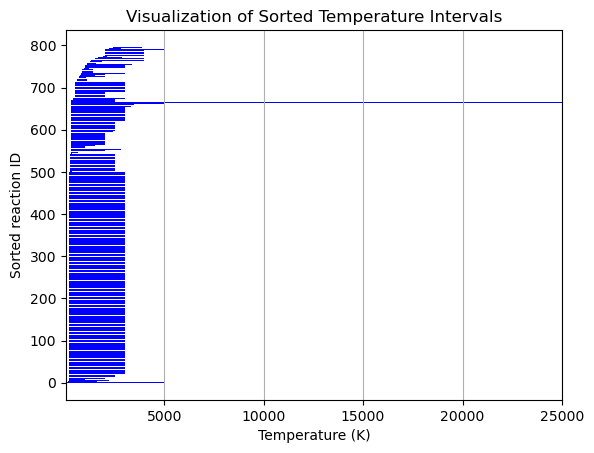

In [60]:
# Sort intervals based on the left limit
sorted_intervals = sorted(intervals, key=lambda x: x[1])
sorted_intervals = sorted(sorted_intervals, key=lambda x: x[0])

# Extract left and right limits from sorted intervals
left_limits, right_limits = zip(*sorted_intervals)

global_t_min = min(left_limits)
global_t_max = max(right_limits)

# Plot the sorted intervals using horizontal bars
plt.figure()
plt.barh(range(len(sorted_intervals)), width=[r - l for l, r in sorted_intervals], left=left_limits, color='blue', alpha=1)
plt.title('Visualization of Sorted Temperature Intervals')
plt.xlim([global_t_min, global_t_max])
plt.xlabel('Temperature (K)')
plt.ylabel('Sorted reaction ID')
plt.grid(axis='x')
plt.show()


In [61]:
data = defaultdict(list)
reaction_count = 0
for sample in tqdm(T_reaction_list):
    k = sample.kinetics_property

    if k.Tmin:
        t_min = k.Tmin.value_si
    else:
        t_min = global_t_min
    
    if k.Tmax:
        t_max = k.Tmax.value_si
    else:
        t_max = 3000

    for T in np.arange(t_min, t_max, 300).tolist():
        if not k.is_temperature_valid(T):
            continue

        try:
            rate = k.get_rate_coefficient(T)
            assert not np.isnan(np.log10(rate))
            data['library'].append(sample.family_name)
            data['label'].append(input2reaction_label(sample))
            data['smiles'].append(input2reaction_smiles(sample))
            data['domain_index'].append(T)
            data['target'].append(np.log10(rate))
        except:
            continue
    reaction_count += 1

df = pd.DataFrame(data)
print(reaction_count, len(df))

  0%|          | 0/29539 [00:00<?, ?it/s]

/miniconda/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/miniconda/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


29539 293452


/miniconda/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


In [62]:
df.to_csv("library_T_dependent_300k.csv", index=False)

## Temperature Pressure Dependence

### Redundancy reduced

In [63]:
available_condition = []
for sample in TP_reaction_list_reduced:
    k = sample.kinetics_property
    if k.Tmax is not None and k.Tmin is not None and k.Pmax is not None and k.Pmin is not None:
        available_condition.append(
            (k.Tmin.value_si,
             k.Tmax.value_si,
             k.Pmin.value_si,
             k.Pmax.value_si)
        )
print(len(available_condition))

60


In [64]:
from matplotlib.patches import Rectangle

# Function to draw rectangles given min and max coordinates
def draw_rectangle(ax, x_min, x_max, y_min, y_max, color='blue'):
    rectangle = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='black', alpha=0.1)
    ax.add_patch(rectangle)

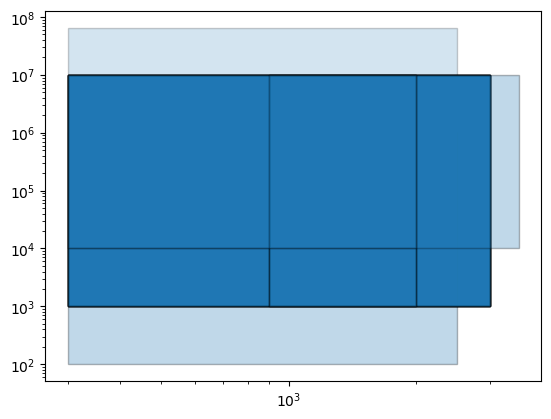

In [65]:
# Create a figure and axis
fig, ax = plt.subplots()

# Define rectangles using min and max coordinates
for x_min, x_max, y_min, y_max in available_condition:
    draw_rectangle(ax, x_min, x_max, y_min, y_max, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
    
plt.show()

In [66]:
global_t_min = min(tmin for tmin, *_ in available_condition)
global_t_max = min(tmax for _, tmax, *_ in available_condition)
global_p_min = min(pmin for *_, pmin, _ in available_condition)
global_p_max = min(pmax for *_, pmax in available_condition)

In [67]:
data = defaultdict(list)
reaction_count = 0
for sample in tqdm(TP_reaction_list_reduced):
    k = sample.kinetics_property

    if k.Tmin:
        t_min = k.Tmin.value_si
    else:
        t_min = global_t_min

    if k.Tmax:
        t_max = k.Tmax.value_si
    else:
        t_max = global_t_max
        
    if k.Pmin:
        p_min = k.Pmin.value_si
    else:
        p_min = global_p_min
    
    if k.Pmax:
        p_max = k.Pmax.value_si
    else:
        p_max = global_p_max

    for T in np.arange(t_min, t_max, 300).tolist():
        for P in np.logspace(np.log10(p_min), np.log10(p_max), 8).tolist():
            if not (k.is_temperature_valid(T) and k.is_pressure_valid(P)):
                continue

            try:
                rate = k.get_rate_coefficient(T, P)
                assert not np.isnan(np.log10(rate))
                data['label'].append(sample.family_name)
                data['smiles'].append(input2reaction_smiles(sample))
                data['domain_index'].append((T, P))
                data['target'].append(np.log10(rate))
            except:
                continue
    reaction_count += 1

df = pd.DataFrame(data)

  0%|          | 0/861 [00:00<?, ?it/s]

In [68]:
print(reaction_count, len(df))

861 42160


In [69]:
df.to_csv("library_TP_dependent_reduced_42k.csv", index=False)

### Redundancy remained

In [70]:
available_condition = []
for sample in TP_reaction_list:
    k = sample.kinetics_property
    if k.Tmax is not None and k.Tmin is not None and k.Pmax is not None and k.Pmin is not None:
        available_condition.append(
            (k.Tmin.value_si,
             k.Tmax.value_si,
             k.Pmin.value_si,
             k.Pmax.value_si)
        )
print(len(available_condition))

61


In [71]:
from matplotlib.patches import Rectangle

# Function to draw rectangles given min and max coordinates
def draw_rectangle(ax, x_min, x_max, y_min, y_max, color='blue'):
    rectangle = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='black', alpha=0.1)
    ax.add_patch(rectangle)

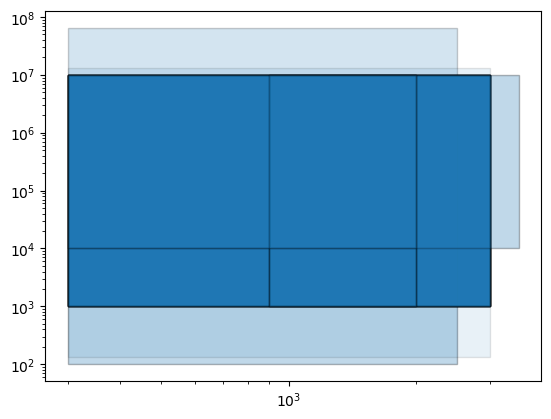

In [72]:
# Create a figure and axis
fig, ax = plt.subplots()

# Define rectangles using min and max coordinates
for x_min, x_max, y_min, y_max in available_condition:
    draw_rectangle(ax, x_min, x_max, y_min, y_max, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
    
plt.show()

In [73]:
global_t_min = min(tmin for tmin, *_ in available_condition)
global_t_max = min(tmax for _, tmax, *_ in available_condition)
global_p_min = min(pmin for *_, pmin, _ in available_condition)
global_p_max = min(pmax for *_, pmax in available_condition)

In [74]:
data = defaultdict(list)
reaction_count = 0
for sample in tqdm(TP_reaction_list):
    k = sample.kinetics_property

    if k.Tmin:
        t_min = k.Tmin.value_si
    else:
        t_min = global_t_min

    if k.Tmax:
        t_max = k.Tmax.value_si
    else:
        t_max = global_t_max
        
    if k.Pmin:
        p_min = k.Pmin.value_si
    else:
        p_min = global_p_min
    
    if k.Pmax:
        p_max = k.Pmax.value_si
    else:
        p_max = global_p_max

    for T in np.arange(t_min, t_max, 300).tolist():
        for P in np.logspace(np.log10(p_min), np.log10(p_max), 8).tolist():
            if not (k.is_temperature_valid(T) and k.is_pressure_valid(P)):
                continue

            try:
                rate = k.get_rate_coefficient(T, P)
                assert not np.isnan(np.log10(rate))
                data['label'].append(sample.family_name)
                data['smiles'].append(input2reaction_smiles(sample))
                data['domain_index'].append((T, P))
                data['target'].append(np.log10(rate))
            except:
                continue
    reaction_count += 1

df = pd.DataFrame(data)

  0%|          | 0/3471 [00:00<?, ?it/s]

In [75]:
print(reaction_count, len(df))

3471 167407


In [76]:
df.to_csv("library_TP_dependent_167k.csv", index=False)